In [15]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import time
import os
import psutil
import shelve
from pybdm import BDM
from pybdm.utils import decompose_dataset
from joblib import Parallel, delayed
from joblib import parallel_backend
from data.algorithms import PerturbationExperiment, NodePerturbationExperiment
import math
import datetime
from itertools import product

In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/juan/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Number of side effects

In [43]:
SE = pd.read_csv('data/original_data/bio-decagon-effectcategories.csv',sep=',')
DDI = pd.read_csv('data/clean_data/new-decagon-combo.csv',sep=',')
DSE = pd.read_csv('data/clean_data/new-decagon-mono.csv',sep=',')

In [29]:
print(len(SE['Side Effect'].values))
print(len(pd.unique(SE['Side Effect'].values)))
SE.head()

561
561


,Side Effect,Side Effect Name,Disease Class
0,C0017152,gastric inflammation,gastrointestinal system disease
1,C0027858,neuroma,benign neoplasm
2,C0041466,Typhoid,bacterial infectious disease
3,C0032807,Post thrombotic syndrome,cardiovascular system disease
4,C0033860,psoriasis,integumentary system disease


In [75]:
DDI = pd.read_csv('data/clean_data/new-decagon-combo.csv',sep=',')
print(len(DDI['Polypharmacy Side Effect'].values))
print(len(pd.unique(DDI['Polypharmacy Side Effect'].values)))
DDI['freq'] = DDI.groupby('Polypharmacy Side Effect')['Polypharmacy Side Effect'].transform('count')
DDI = DDI.sort_values(by=['freq'], ascending=False).drop(columns=['freq'])
DDI.head()

4615522
1317


,STITCH 1,STITCH 2,Polypharmacy Side Effect,Side Effect Name
630074,CID000003386,CID000003446,C0020649,arterial pressure NOS decreased
378049,CID000001983,CID000003958,C0020649,arterial pressure NOS decreased
638233,CID000093860,CID000148211,C0020649,arterial pressure NOS decreased
2529493,CID000003386,CID000004595,C0020649,arterial pressure NOS decreased
3590526,CID000003419,CID000003958,C0020649,arterial pressure NOS decreased


In [72]:
len(pd.unique(DDI['Polypharmacy Side Effect'].values)[:964])

964

In [34]:
print(len(DSE['Individual Side Effect'].values))
print(len(pd.unique(DSE['Individual Side Effect'].values)))
DSE.head()

174977
10184


,STITCH,Individual Side Effect,Side Effect Name
0,CID003062316,C1096328,central nervous system mass
1,CID003062316,C0162830,Photosensitivity reaction
2,CID003062316,C1611725,leukaemic infiltration brain
3,CID003062316,C0541767,platelet adhesiveness abnormal
4,CID003062316,C0242973,Ventricular dysfunction


### experimenting with pickle

In [3]:
import pickle
import numpy as np
import scipy.sparse as sp

In [5]:
with open('./data/data_structures/bdm_CMM', 'rb') as f:
    data_decagon = pickle.load(f)
    for key in data_decagon.keys():
        globals()[key]=data_decagon[key]
        print(key,"Imported successfully")

UnpicklingError: invalid load key, '\xcf'.

In [6]:
with open('./data/data_structures/decagon.pickle', 'rb') as f:
    vms = pickle.load(f)['vms_ddi']

## Playing with datetime

In [ ]:
now = datetime.datetime.now() # current date and time
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")
date_name = year+'-'+month+'-'+day
print(date_name)

## Loading BDM data from CMM

In [4]:
data_bdm = shelve.open("./data/data_structures/bdm_CMM")
for key in data_bdm:
    globals()[key]=data_bdm[key]
    print(key,"Imported successfully")
data_bdm.close()

rss Imported successfully
vms Imported successfully
bdm_drugs_dti Imported successfully
bdm_ddi_list Imported successfully
bdm_ppi Imported successfully
total_time Imported successfully
bdm_genes_dti Imported successfully


In [5]:
print('Total Time:',datetime.timedelta(seconds=total_time))
print('Virtual Memory:',vms*1e-9,'Gb')
print('RSS Memory:',rss*1e-9,'Gb')
print('16 cores')

Total Time: 3 days, 1:13:16.250093
Virtual Memory: 4.583919616 Gb
RSS Memory: 2.214682624 Gb
16 cores


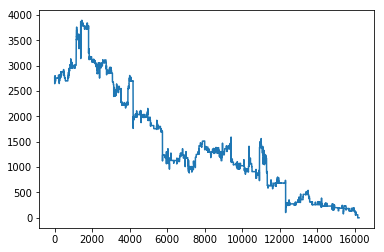

In [8]:
plot(bdm_ppi)

3


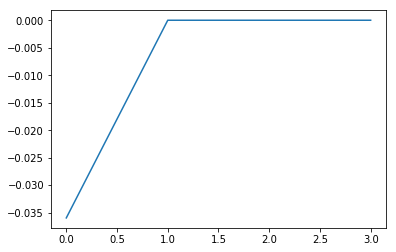

In [13]:
print(len(bdm_ppi)%4)
plot(bdm_ppi[-4:])

In [ ]:
print(np.shape(bdm_ddi_list))
print(np.shape(ddi_adj_list))

In [ ]:
plot(bdm_ddi_list[0][1])
#plot(bdm_ddi_list[0][0])

## Username testing

In [ ]:
from getpass import getuser
username = getuser()
print(username)
jobs = 16
filename ='ppi_bdm_'+ username + str(jobs)
print(filename)

### Tests Parallelization

In [ ]:
N = 16226
b = np.random.randint(0,2,(N,N))
X = ((b + b.T)/2).astype(int)
bdm = BDM(ndim=2)

In [ ]:
perturbation = NodePerturbationExperiment(bdm, metric='bdm',bipartite_network=False)
start = time.time()
perturbation.set_data(X)
perturbation.perturb(1)
print(time.time()-start)

In [ ]:
start = time.time()
val = bdm.bdm(X)
print(time.time()-start)
print(val)

In [ ]:
start = time.time()
counters = Parallel(n_jobs=8)\
    (delayed(bdm.decompose_and_count)(d) for d in decompose_dataset(X, (4056, 4056)))

val = bdm.compute_bdm(*counters)
print(time.time()-start)
print(val)

In [ ]:
N = 1000
b = np.random.randint(0,2,(N,N))
X = ((b + b.T)/2).astype(int)
bdm = BDM(ndim=2)

In [ ]:
perturbation = NodePerturbationExperiment(bdm, metric='bdm',bipartite_network=False,
                                         parallel=False)
start = time.time()
perturbation.set_data(X)
a = perturbation.run()
print(time.time()-start)
print(a[:5])

In [ ]:
perturbation = NodePerturbationExperiment(bdm, metric='bdm',bipartite_network=False,
                                         parallel=True,jobs=8)
start = time.time()
perturbation.set_data(X)
perturbation.run()
print(time.time()-start)
print(a[:5])

# Time experiments (DO NOT DELETE!)
In this experiment we see time of execution in series and in parallel of the `run()` function of the class NodePerturbationExperiment with different matrix sizes.

In [ ]:
# Data taken manually
N = np.array([10,50,100,200,400,500,700,800,900,1000])
S = np.array([0.030,0.114,0.813,6.7217,59.91,109.85,295.385,427.798,622.127,844.55])
P = np.array([1.20,4.129,7.370,22.910,52.55,68.289,122.082,166.802,225.77,300.792])

In [ ]:
zs,rs,_,_,_ = np.polyfit(N,S,4,full=True)
p_ser = np.poly1d(zs)
zp,rp,_,_,_ = np.polyfit(N,P,4,full=True)
p_par = np.poly1d(zp)
print(rs,rp)
figure(figsize=[12,8])
subplot(2,1,1)
plot(N,S,label='Series',linewidth=3)
plot(N,P,label='Parallel jobs=8',linewidth=3)
plot(N,p_ser(N),'--',label='Fit series')
plot(N,p_par(N),'--',label='fit parallel')
legend()
subplot(2,1,2)
loglog(N,S,label='Series',linewidth=3)
loglog(N,P,label='Parallel',linewidth=3)
legend()
show()

In [ ]:
print(datetime.timedelta(seconds=p_ser(16227)))
print(datetime.timedelta(seconds=p_par(16227)))